In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd

from typing import List, Dict
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [2]:
stop_words = set(stopwords.words("english"))

In [3]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [4]:
#read the dataset with name "cyber.csv" and store it in a variable df
cyber = pd.read_csv("/home/sangramdh/jupyter/NLP/text_classification/data/cybersecurity_tweets.csv", usecols=['text','label'])

#print the shape of dataframe
print(cyber.shape)

#print top 5 rows
cyber.head(555)

(200000, 2)


text label
0    #AI Robo-Advisers and the Future of Financial ...     1
1    Hackers causing havoc on Mexican banking syste...     1
2    CVE-2019-13127 An issue was discovered in mxGr...     1
3    How to protect your online identity #labourcyb...     1
4    Forensic Acquisition - Shadow Cyber Sec  https...     1
..                                                 ...   ...
550  The CyberWarrior Wisdom of Master OTW #wisdom ...     1
551  Healthcare Cybersecurity Starts, Ends with Emp...     1
552  I just pwned Ophiuchi in Hack The Box! https:/...     1
553  Curso gratuito de Kali GNU Linux y Workshop #C...     1
554  How hackers can use AI to hide their malware a...     1

[555 rows x 2 columns]

In [5]:
#read the dataset with name "non_cyber.csv" and store it in a variable df
non_cyber = pd.read_csv("/home/sangramdh/jupyter/NLP/text_classification/data/not_cybersecurity_tweets.csv", usecols=['text', 'label'])

#print the shape of dataframe
print(non_cyber.shape)

#print top 5 rows
non_cyber.head()

(200000, 2)


text label
0  Samsung Galaxy Tab Active Pro review: Rugged, ...     0
1  Malware on Target - Pages 4 and 5 #fnaf  See a...     0
2  A curated list of amazingly awesome OSINT: htt...     0
3  Thank you for tipping for Zero-day tokens for ...     0
4  From making sure they don't fall for phishing ...     0

### Check uniques values in "label" column

In [6]:
cyber.label.unique() # for cyber dataset

array(['1', ' #CyberSecurity for Power Systems',
       ' A New Wake Up Call https://t.co/yBYOsLGIfi #cybersecurity',
       ' https://t.co/BenGo8OxLk',
       ' Nursing Essays Criminology English Ecology Literature Law Algebra History Excel Homework #MachineLearning  #DataScience #tech #100DaysOfCode #Python #Cybersecurity #BigData #AI  #DeepLearning #ArtificialIntelligence #NLP #Brands  Dm @GraceyEssays https://t.co/jTjW07Uuym',
       ' Access Requests #GDPR #cybersecurity #security via https://t.co/zeb5hNqb8q https://t.co/20xnomxaZK',
       'quot',
       'R√©partition DR  Biden s‚Äôentretiendra avec d‚Äôautres leaders mondiaux sur les attaques de ransomware. R√©union pour cr√©er une alliance ...   https://t.co/hFe0SwwViK #French https://t.co/3biiMPjKOt',
       ' entenda como a amea√ßa ransomware age ‚Äì\xa0Tilt https://t.co/LwI0Tuhf0N',
       ' Tile Trackers & Amazon',
       ' Microsoft Is Exposed | #microsoft | #hacking |\xa0#cybersecurity https://t.co/Mo2L56BjVH',
       ' c

In [7]:
cyber[-10:]

text label
199990  I gave +Kred to @Shirastweet on @Kred #influen...     1
199991  AXA pledges to stop reimbursing ransom payment...     1
199992  "Researchers warn that PrivateLoader pay-per-i...     1
199993  Well... I started the Journey into #CyberSecur...     1
199994  Know More About Cybersecurity and Data Privacy...     1
199995  #Webinar Our so much awaited webinar addressin...     1
199996  The threat of #ransomware is nothing new, but ...     1
199997  Shadow Code From Third-Party Libraries Is a Ma...     1
199998  ¬ø"whose our-s-ing as which-s &/or whose-s stat...     1
199999  Senior Manager RGM Retail Programs  #Job #Leba...     1

In [8]:
len(cyber.label.unique()) # check count how many uniques are there

952

In [9]:
non_cyber.label.unique() # check for non_cyber dataset

array(['0', ' thousands clicked through https://t.co/k2Q49rERql',
       ' this opens up a whole new window for the bad guys.  https://t.co/V3UclU9qrh  #kubernetes #windows #cyberscurity #malwareattack',
       ..., ' https://t.co/IScXnqp4is',
       " the number of concerned colleagues who generously reach out to let you know you've been used in a phishing attempt ‚ò∫Ô∏è",
       " investigation 'ongoing' https://t.co/h0k4Eq0pOG #uncategorized #feedly"],
      dtype=object)

In [10]:
len(non_cyber.label.unique())

1098

#### I'm getting here at label column in both the dataset, some unique which is not good.
we need to clean that so that we can move forword

In [11]:
cyber['label'] = cyber.label.replace(cyber.label.unique(), 1) # replacing the value for cyber dataset

In [12]:
cyber_labeled = cyber

In [13]:
cyber_labeled.head()

text  label
0  #AI Robo-Advisers and the Future of Financial ...      1
1  Hackers causing havoc on Mexican banking syste...      1
2  CVE-2019-13127 An issue was discovered in mxGr...      1
3  How to protect your online identity #labourcyb...      1
4  Forensic Acquisition - Shadow Cyber Sec  https...      1

In [14]:
len(cyber_labeled.label.unique())

1

In [15]:
non_cyber['label'] = non_cyber.label.replace(non_cyber.label.unique(), 0)

In [16]:
non_cyber_labeled = non_cyber

In [17]:
non_cyber_labeled.head()

text  label
0  Samsung Galaxy Tab Active Pro review: Rugged, ...      0
1  Malware on Target - Pages 4 and 5 #fnaf  See a...      0
2  A curated list of amazingly awesome OSINT: htt...      0
3  Thank you for tipping for Zero-day tokens for ...      0
4  From making sure they don't fall for phishing ...      0

In [18]:
len(non_cyber_labeled.label.unique())

1

In [19]:
#check the distribution of labels 
print(non_cyber_labeled['label'].value_counts())

0    200000
Name: label, dtype: int64


### concanet the data frame => cyber_labeled + non_cyber_labeled = data

In [20]:
# concatenating df1 and df2 along rows
data = pd.concat([cyber_labeled, non_cyber_labeled], axis=0, ignore_index=True)
print(data.shape)
data.head()

(400000, 2)


text  label
0  #AI Robo-Advisers and the Future of Financial ...      1
1  Hackers causing havoc on Mexican banking syste...      1
2  CVE-2019-13127 An issue was discovered in mxGr...      1
3  How to protect your online identity #labourcyb...      1
4  Forensic Acquisition - Shadow Cyber Sec  https...      1

In [21]:
#check the distribution of labels 
print(data['label'].value_counts())

1    200000
0    200000
Name: label, dtype: int64


In [22]:
len(data.label.unique())

2

In [23]:
# def preprocess_txt(text: str , remove_stopwords: bool) -> List[str]:

#     # Remove links
#     text = re.sub(r"http\S+", "", text)
    
#     # remove special chars and numbers
#     text = re.sub("[^A-Za-z]+", " ", text)
    
#     # remove stopwords
#     if remove_stopwords:
#         # 1. tokenize
#         tokens = nltk.word_tokenize(text)
        
#         # 2. check if stopword
#         tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        
#         # 3. join back together
#         text = " ".join(tokens)
        
#     # return text in lower case and stripped of whitespaces
#     text = text.lower().strip()
#     return text


In [24]:
# data['text_tokens'] = data['text'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [25]:
def preprocess_text(text: str) -> List[str]:
    # Remove links
    text = re.sub(r"http\S+", "", text)
    
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    text = text.lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )
    text_tokens = word_tokenize(text)
    text_without_stopwords = [word for word in text_tokens if word not in stop_words]
    return text_without_stopwords

In [26]:
xd = preprocess_text(data['text'][0])
xd

['ai',
 'robo',
 'advisers',
 'future',
 'financial',
 'advice',
 'dataprotection',
 'privacy',
 'infosec',
 'cybersecurity',
 'bigdata',
 'ai']

In [27]:
data["text_tokens"] = data["text"].apply(lambda x: preprocess_text(x))

In [28]:
data.head()

text  label  \
0  #AI Robo-Advisers and the Future of Financial ...      1   
1  Hackers causing havoc on Mexican banking syste...      1   
2  CVE-2019-13127 An issue was discovered in mxGr...      1   
3  How to protect your online identity #labourcyb...      1   
4  Forensic Acquisition - Shadow Cyber Sec  https...      1   

                                         text_tokens  
0  [ai, robo, advisers, future, financial, advice...  
1  [hackers, causing, havoc, mexican, banking, sy...  
2  [cve, issue, discovered, mxgraph, related, dia...  
3  [protect, online, identity, labourcyberattack,...  
4  [forensic, acquisition, shadow, cyber, sec, cy...

In [29]:
cleaned_text_tokens = data['text_tokens'].values

In [30]:
cleaned_text_tokens[5]

['time',
 'pursue',
 'international',
 'cyber',
 'treaty',
 'nation',
 'cybersecurity',
 'infosec',
 'treaty',
 'international']

In [205]:
w2v_model = Word2Vec(sentences=cleaned_text_tokens, vector_size=100)

In [206]:
print(w2v_model)

Word2Vec<vocab=48846, vector_size=100, alpha=0.025>


In [207]:
w2v_model.wv.most_similar("ai")

[('innovation', 0.5327626466751099),
 ('aibias', 0.4998008906841278),
 ('gans', 0.4986218214035034),
 ('sensors', 0.4890519976615906),
 ('snndc', 0.4848827123641968),
 ('automation', 0.481969952583313),
 ('produce', 0.4666871726512909),
 ('openai', 0.46201637387275696),
 ('predictiveanalytics', 0.45997318625450134),
 ('innovative', 0.4555313289165497)]

In [208]:
def sent_vec(sent):
    vector_size = w2v_model.vector_size
    wv_res = np.zeros(vector_size)
    # print(wv_res)
    ctr = 1
    for w in sent:
        if w in w2v_model.wv:
            ctr += 1
            wv_res += w2v_model.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [209]:
data['vector'] = data['text_tokens'].apply(sent_vec)
data.head()

text  label  \
0  #AI Robo-Advisers and the Future of Financial ...      1   
1  Hackers causing havoc on Mexican banking syste...      1   
2  CVE-2019-13127 An issue was discovered in mxGr...      1   
3  How to protect your online identity #labourcyb...      1   
4  Forensic Acquisition - Shadow Cyber Sec  https...      1   

                                         text_tokens  \
0  [ai, robo, advisers, future, financial, advice...   
1  [hackers, causing, havoc, mexican, banking, sy...   
2  [cve, issue, discovered, mxgraph, related, dia...   
3  [protect, online, identity, labourcyberattack,...   
4  [forensic, acquisition, shadow, cyber, sec, cy...   

                                              vector  
0  [-1.5062783383406126, 0.2905902861116024, 0.30...  
1  [-0.8000948880799115, 0.6700714640319347, 0.53...  
2  [-0.26206380863570505, 0.7194017469882965, 0.8...  
3  [-1.567341387271881, 0.006551363815863927, 0.1...  
4  [-1.3461534907420476, 0.2444593181212743, -0.2...

In [210]:
# X = data['vector'].to_list()
# y = data['label'].to_list()

In [211]:
data['label'][9999]

1

### Trying with TF-IDF also

In [213]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vectorizer = TfidfVectorizer()

In [214]:
def tfidf_score(text):
    for i in text:
        print(i)
        da = vectorizer.fit_transform(i).toarray()
        return da
a = tfidf_score(data['text_tokens'][:10])
print(a)

['ai', 'robo', 'advisers', 'future', 'financial', 'advice', 'dataprotection', 'privacy', 'infosec', 'cybersecurity', 'bigdata', 'ai']
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [215]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    data.vector.values, 
    data.label, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=data.label
)

In [216]:
X_train

array([array([-5.88249715e-01,  4.94763244e-01,  5.50370617e-02,  2.57485614e-01,
               1.04053285e-01,  4.32218292e-01, -1.94463862e-01,  4.70535850e-01,
              -2.57630344e-03,  5.84923178e-01, -3.30177665e-01,  4.00407819e-01,
              -5.54580430e-01,  3.72158587e-01,  2.47618521e-01, -2.46007893e-01,
              -4.88108626e-01, -4.00947807e-02, -7.44088445e-01, -2.09597571e-01,
              -3.92306020e-01,  8.42526801e-01,  1.21301750e-01, -4.43689190e-02,
              -1.98269621e-01, -5.54367222e-01, -4.41711396e-04,  2.06747191e-01,
               6.94507435e-01, -4.06159274e-03,  7.45377783e-02, -3.14270223e-01,
              -5.41525608e-01,  1.23848634e-01, -4.74096417e-01,  4.11366638e-01,
               4.72912230e-01, -5.73134972e-01,  5.87174958e-01,  5.85036225e-01,
              -2.88175785e-01,  5.72147314e-01,  9.11621435e-02, -1.70736194e-01,
              -1.31849676e-01, -5.17111123e-02, -1.63344231e-01,  3.16967720e-01,
              -9

In [217]:
X_train.shape, X_test.shape

((320000,), (80000,))

In [218]:
y_train.shape, y_test.shape

((320000,), (80000,))

### ```Classifier expects 2d numpy array so using stack we can do that```

In [219]:
X_train_2d = np.stack(X_train) # there was array inside array so for mitigation of that we used stack
X_test_2d =  np.stack(X_test)

In [220]:
X_train_2d[0]

array([-5.88249715e-01,  4.94763244e-01,  5.50370617e-02,  2.57485614e-01,
        1.04053285e-01,  4.32218292e-01, -1.94463862e-01,  4.70535850e-01,
       -2.57630344e-03,  5.84923178e-01, -3.30177665e-01,  4.00407819e-01,
       -5.54580430e-01,  3.72158587e-01,  2.47618521e-01, -2.46007893e-01,
       -4.88108626e-01, -4.00947807e-02, -7.44088445e-01, -2.09597571e-01,
       -3.92306020e-01,  8.42526801e-01,  1.21301750e-01, -4.43689190e-02,
       -1.98269621e-01, -5.54367222e-01, -4.41711396e-04,  2.06747191e-01,
        6.94507435e-01, -4.06159274e-03,  7.45377783e-02, -3.14270223e-01,
       -5.41525608e-01,  1.23848634e-01, -4.74096417e-01,  4.11366638e-01,
        4.72912230e-01, -5.73134972e-01,  5.87174958e-01,  5.85036225e-01,
       -2.88175785e-01,  5.72147314e-01,  9.11621435e-02, -1.70736194e-01,
       -1.31849676e-01, -5.17111123e-02, -1.63344231e-01,  3.16967720e-01,
       -9.42134699e-02,  1.97145397e-01, -3.57550245e-01,  2.15987340e-02,
        6.64540380e-01,  

In [221]:
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(penalty='l2').fit(X_train_2d, y_train)

In [222]:
LR_pred = clf_LR.predict(X_test_2d)

In [223]:
print(classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     40000
           1       0.94      0.91      0.93     40000

    accuracy                           0.93     80000
   macro avg       0.93      0.93      0.93     80000
weighted avg       0.93      0.93      0.93     80000



In [176]:
text = "The state-backed Russian cyber spies behind the SolarWinds hacking campaign launched a targeted spear-phishing assault on U.S. and foreign government agencies and think tanks this week using an email marketing account of the U.S. Agency for International Development."

Text(95.72222222222221, 0.5, 'Truth')

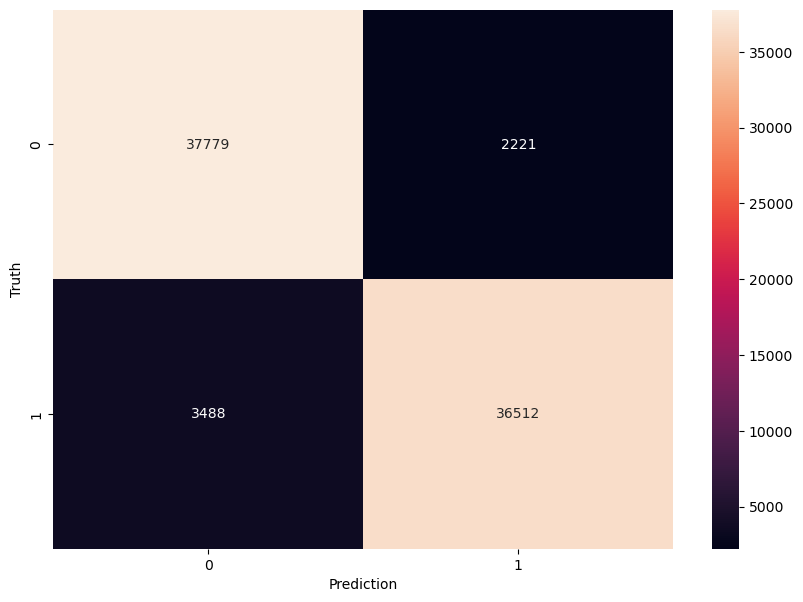

In [224]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, LR_pred)
cm

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [226]:
# loading library
import pickle
# create an iterator object with write permission - model_clf_NB.pkl
with open('model_LR_v3.pkl', 'wb') as files:
    pickle.dump(clf_LR, files)

In [227]:
def load_model():
    #return pickle.load(MODELS_PATH)

    # Open the file in binary mode
    with open("model_LR_v2.pkl", 'rb') as file:
      
    # Call load method to deserialze
        modl = pickle.load(file)
        return modl

LOADED_MODEL = load_model()

## Modeling

### Naive_bayes Classifier

#### ``` It doesn't work with negative values```

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sn

In [45]:
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf_NB = MultinomialNB()
clf_NB.fit(scaled_train_embed, y_train)

MultinomialNB()

In [62]:
from sklearn.metrics import classification_report

In [47]:
y_pred_NB = clf_NB.predict(scaled_test_embed)

print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80     40000
           1       0.82      0.75      0.78     40000

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



In [50]:
clf_NB.predict_proba(scaled_test_embed)[0]

array([0.62494644, 0.37505356])

Text(95.72222222222221, 0.5, 'Truth')

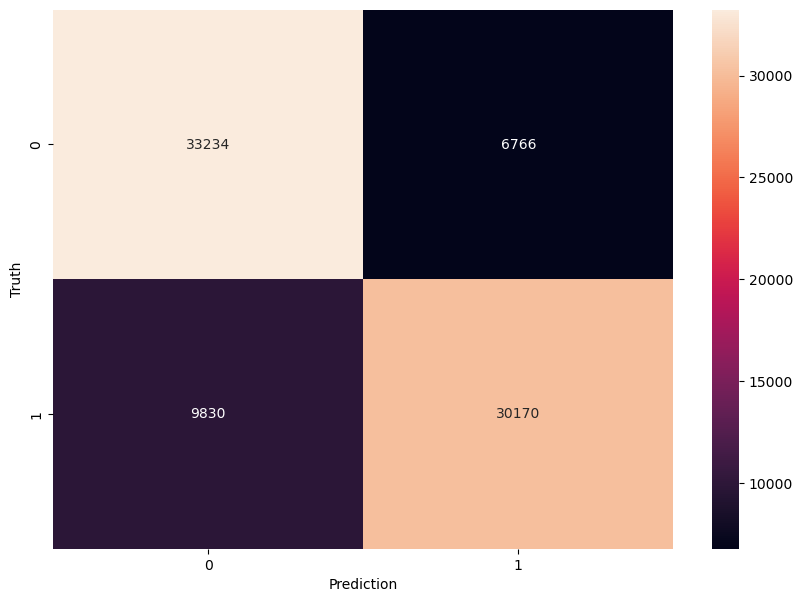

In [51]:
#finally print the confusion matrix for the best model (MultinomialNB)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_NB)
cm

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

### ``` Here in this problem ~False Negative~(FN) is dengerous, because if it is crime or predicted as not a crime will be not good```

In [52]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flint√¢‚Ç¨‚Ñ¢s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnaires√¢‚Ç¨‚Ñ¢ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. √¢‚Ç¨≈ìMy testimony was truthful and I stand by it,√¢‚Ç¨¬ù Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the state√¢‚Ç¨‚Ñ¢s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnaires√¢‚Ç¨‚Ñ¢ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_ = [preprocess_text(n) for n in test_news]
test_vectors = [sent_vec(n) for n in test_news_]
test_2d =  np.stack(test_vectors)
scaled_test_embed = scaler.transform(test_2d)

clf_NB.predict(scaled_test_embed)

array([0, 0, 0])

In [53]:
# loading library
import pickle
# create an iterator object with write permission - model_clf_NB.pkl
with open('model_clf_NB.pkl', 'wb') as files:
    pickle.dump(clf_NB, files)

### KNeighborsClassifier

In [54]:
from  sklearn.neighbors import KNeighborsClassifier

#1. creating a KNN model object
clf_KNN = KNeighborsClassifier(n_neighbors = 3, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf_KNN.fit(X_train_2d, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred_KNN = clf_KNN.predict(X_test_2d)

In [55]:
print(clf_KNN.predict_proba(X_test_2d))

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [56]:
#4. print the classfication report
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     40000
           1       0.93      0.93      0.93     40000

    accuracy                           0.93     80000
   macro avg       0.93      0.93      0.93     80000
weighted avg       0.93      0.93      0.93     80000



In [57]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flint√¢‚Ç¨‚Ñ¢s water crisis afterlawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnaires√¢‚Ç¨‚Ñ¢ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. √¢‚Ç¨≈ìMy testimony was truthful and I stand by it,√¢‚Ç¨¬ù Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the state√¢‚Ç¨‚Ñ¢s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnaires√¢‚Ç¨‚Ñ¢ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_ = [preprocess_text(n) for n in test_news]
test_vectors = [sent_vec(n) for n in test_news_]

clf_KNN.predict(test_vectors)

array([1, 1, 0])

Text(95.72222222222221, 0.5, 'Truth')

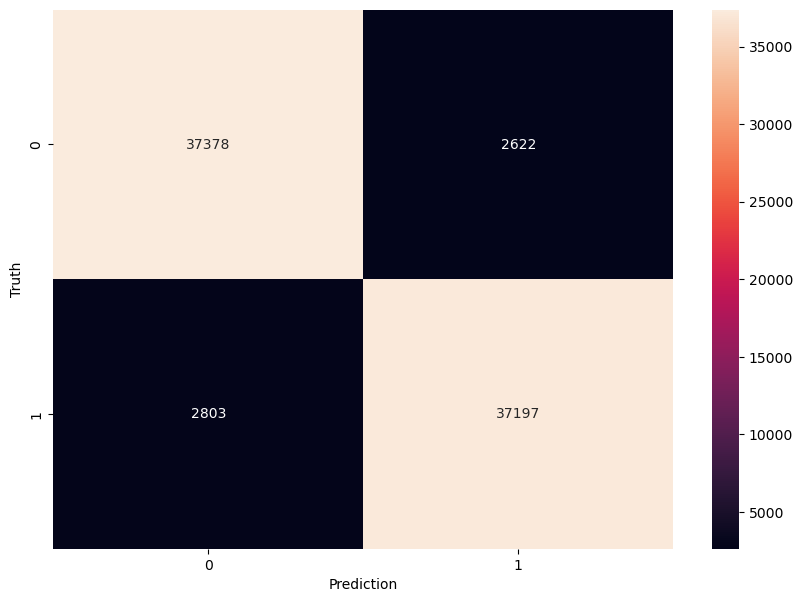

In [58]:
#finally print the confusion matrix for the best model (KNeighborsClassifier)
cm = confusion_matrix(y_test, y_pred_KNN)
cm

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [60]:
# create an iterator object with write permission - KNN_model.pkl
with open('KNN_model.pkl', 'wb') as files:
    pickle.dump(clf_KNN, files)

### Ensemble Technique for classification

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


In [62]:
#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     40000
           1       0.93      0.89      0.91     40000

    accuracy                           0.91     80000
   macro avg       0.91      0.91      0.91     80000
weighted avg       0.91      0.91      0.91     80000



In [63]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flint√¢‚Ç¨‚Ñ¢s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnaires√¢‚Ç¨‚Ñ¢ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. √¢‚Ç¨≈ìMy testimony was truthful and I stand by it,√¢‚Ç¨¬ù Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the state√¢‚Ç¨‚Ñ¢s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnaires√¢‚Ç¨‚Ñ¢ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_ = [preprocess_text(n) for n in test_news]
test_vectors = [sent_vec(n) for n in test_news_]

clf.predict(test_vectors)

array([0, 0, 0])

Text(95.72222222222221, 0.5, 'Truth')

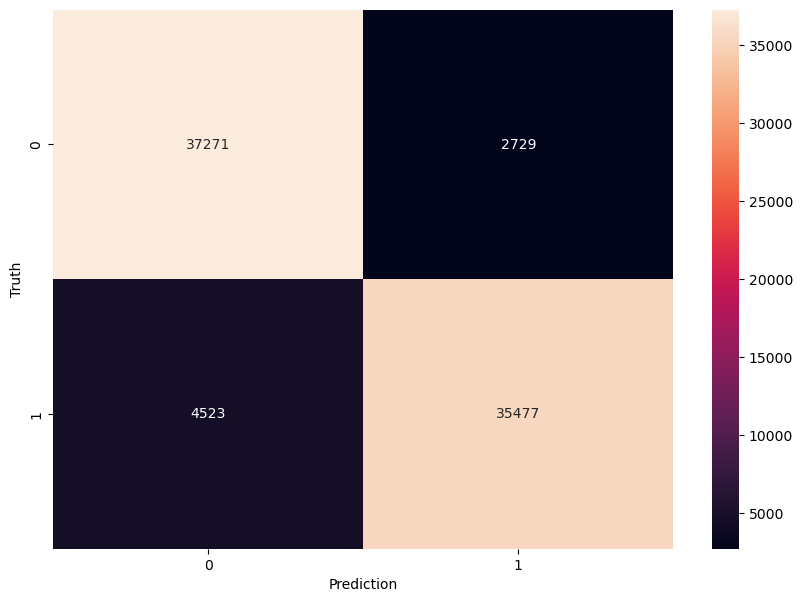

In [64]:
#finally print the confusion matrix for the best model (GradientBoostingClassifier)

cm = confusion_matrix(y_test, y_pred)
cm

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [65]:
# create an iterator object with write permission - ensemble_model_pklV2.pkl
with open('ensemble_model_pklV2.pkl', 'wb') as files:
    pickle.dump(clf, files)

### Prediction verification

In [79]:
testdf = data['text'][200023]
testdf

'El esc√°ndalo de phishing de Opensea revela la necesidad de mejorar la seguridad en el panorama de los\xa0NFT https://t.co/7ggMwYPMsJ'

In [82]:
test_news = [testdf]

test_news_ = [preprocess_text(n) for n in test_news]
test_vectors = [sent_vec(n) for n in test_news_]

clf_KNN.predict(test_vectors)

array([0])

In [144]:
# it was a test
input_test = "Michigan governor denies misleading U.S. House on Flint water (Reuters)"

#test_news_df = pd.DataFrame(test, index=[0])
i_txt = pd.DataFrame({"in_text": str(input_test)}, index=[0])
pre_text = preprocess_text(i_txt["in_text"][0])
w2v_model = Word2Vec(sentences=pre_text, vector_size=300)
vactors = sent_vec(pre_text).reshape(1, -1)
pred = clf.predict(vactors)
pred

array([1])

In [146]:
pre_text

['michigan',
 'governor',
 'denies',
 'misleading',
 'u',
 'house',
 'flint',
 'water',
 'reuters']

In [143]:
if pred == 1:
    print("it a cyber crime")
else:
    print("it's not a cyber crime")

it a cyber crime


#### ``` I'm happy it is classifing correctly any of them```

### I have used here three techniques but they have there one pros and cons

1- Neive bias is fast for training bus FN is more the otheres

2- KNN was good than NB but model size si too much larg

3- Ensemble technique worked well for me model size also was less but it took around 2.30 hours to train